In [9]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [10]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import shutil
import yaml
from rdkit import RDLogger
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def read_yaml(yaml_path: str) -> MCTS:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    file_level = logging.DEBUG if conf.get("debug") else logging.INFO
    logger = make_logger(output_dir, file_level=file_level)
    generator_args = conf.get("generator_args", {})

    transition_args = conf.get("transition_args", {})
    if "model_dir" in transition_args:
        transition_args["model_dir"] = os.path.join(repo_root, transition_args["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_args["model_dir"])) + ".lang"
        lang_path = add_sep(transition_args["model_dir"]) + lang_name
    lang = Language.load(lang_path)
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, device=conf.get("device"), **transition_args)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_args", {}))
    
    if "policy_class" in conf:
        policy_class = class_from_package("policy", conf.get("policy_class"))
        policy = policy_class(**conf.get("policy_args", {}))
        generator_args["policy"] = policy

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
        
    root = MolSentenceNode.bos_node(lang, device=conf.get("device")) # TODO: change after root node generalization
    
    generator_class = class_from_package("generator", conf.get("generator_class", "MCTS"))
    generator = generator_class(root=root, transition=transition, reward=reward, filters=filters, output_dir=output_dir, logger=logger, **generator_args)

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)
    return generator, conf

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_yaml(*args: str):
    for yaml_path in args:
        generator, conf = read_yaml(yaml_path)
        generate_and_analyze(generator, conf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Is CUDA available: False
Starting generation...
<best reward updated> order: 1, time: 0.00, reward: 0.2719, node: CN(CC)C(=O)CNC(=O)c1c(C)nn(-c2ccc(F)cc2)c1C
<best reward updated> order: 3, time: 0.05, reward: 0.3404, node: Oc1ccc(-c2cccc(OCC(F)(F)F)c2)cc1[N+](=O)[O-]
<best reward updated> order: 4, time: 0.07, reward: 0.4312, node: c1nn(CNC[C@@H]2COc3ccccc3O2)cn1
<best reward updated> order: 96, time: 2.45, reward: 0.4348, node: [NH3+]c1c(I)cccc1C(=O)[O-]
<best reward updated> order: 98, time: 2.49, reward: 0.4549, node: [NH3+]c1c(O[C@H]2O[C@@H](CO)[C@H](O)[C@@H]2O)cc(F)cc1F
generated: 100, time: 2.53, average over 100: 0.1808
generated: 200, time: 4.95, average over 100: 0.2073
<best reward updated> order: 210, time: 5.20, reward: 0.4674, node: O[C@@H]([C@@H]1O[C@@H](O)[C@H]1O)[C@@H]1CCOC2(CCC2)C1
<best reward updated> order: 282, time: 6.76, reward: 0.4812, node: OC/C=C/c1c(I)c(I)ccc1F
generated: 300, time: 7.12, average over 100: 0.2424
generated: 400, time: 9.34, average over 100:

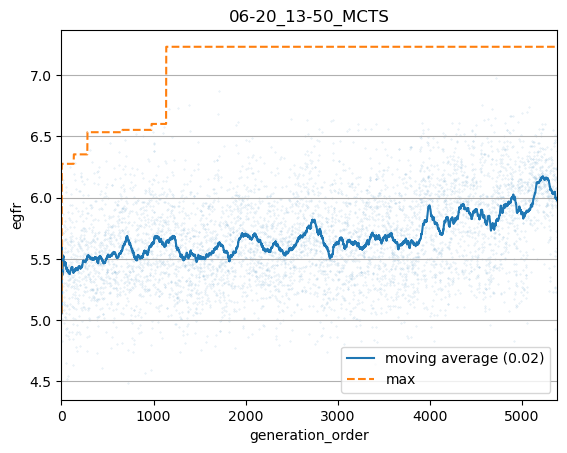

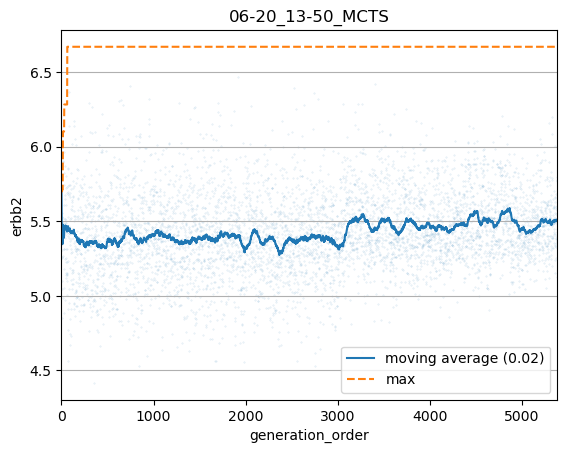

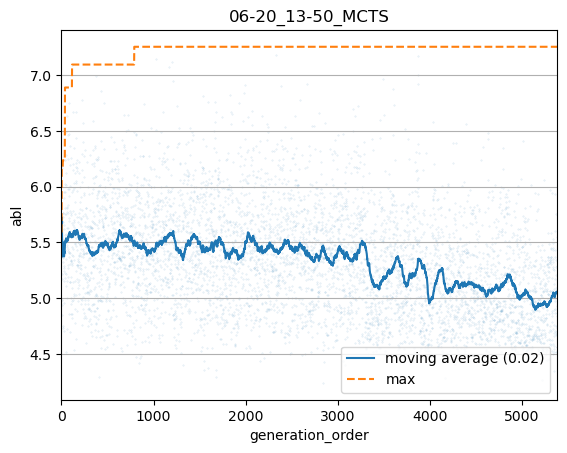

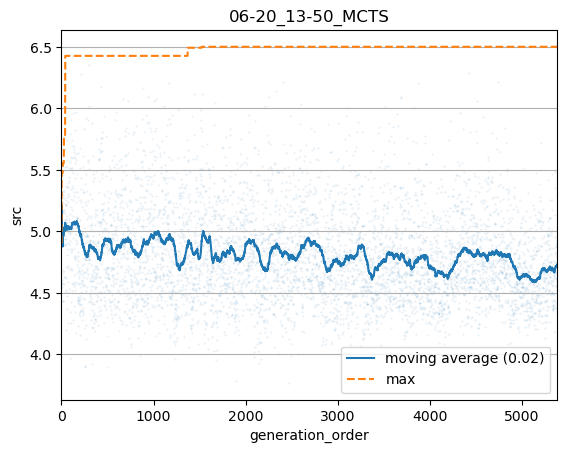

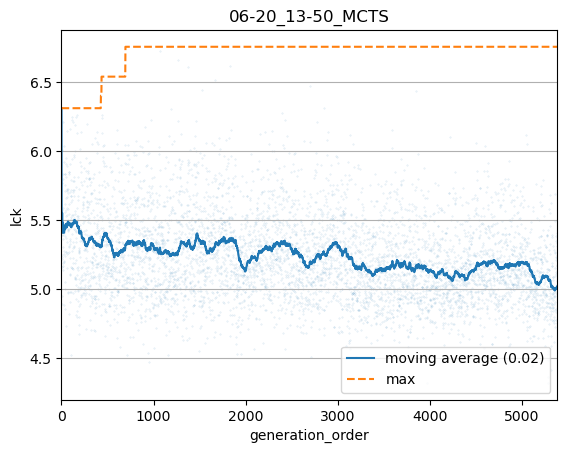

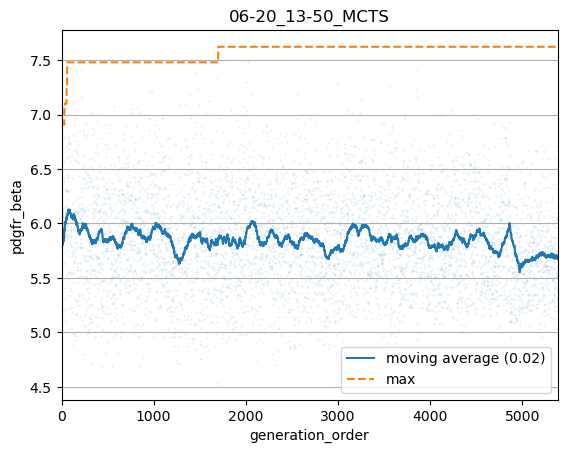

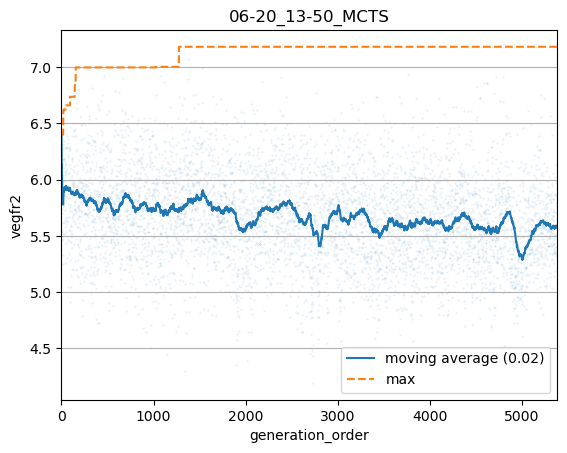

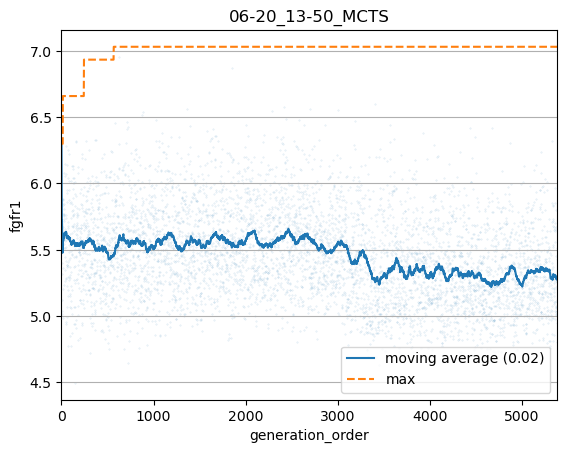

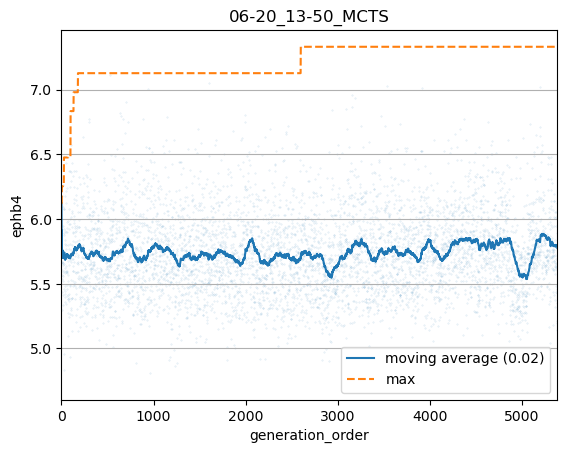

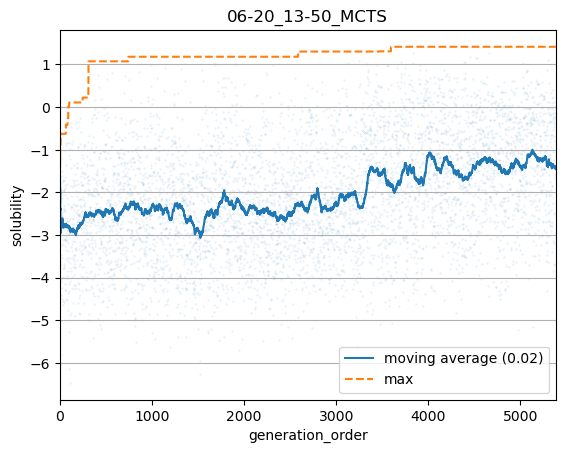

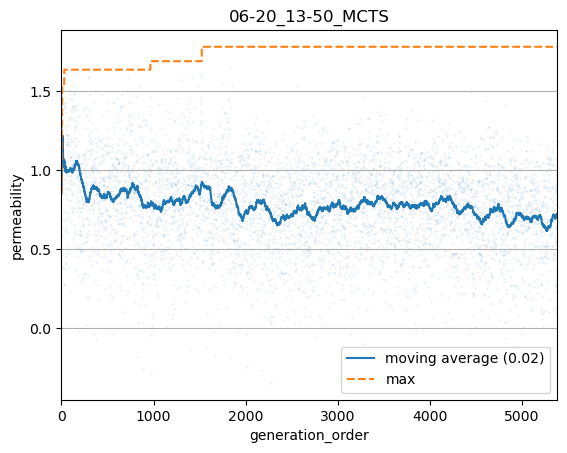

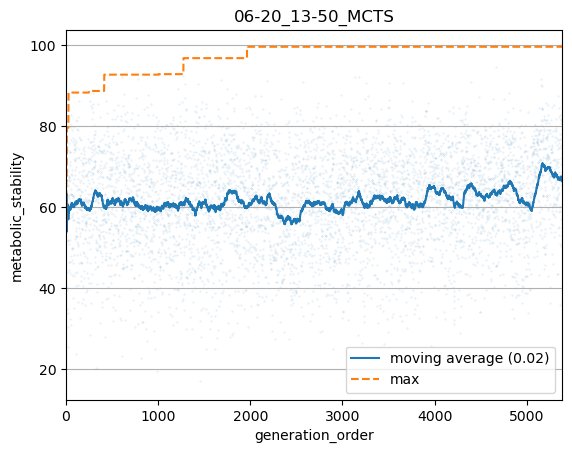

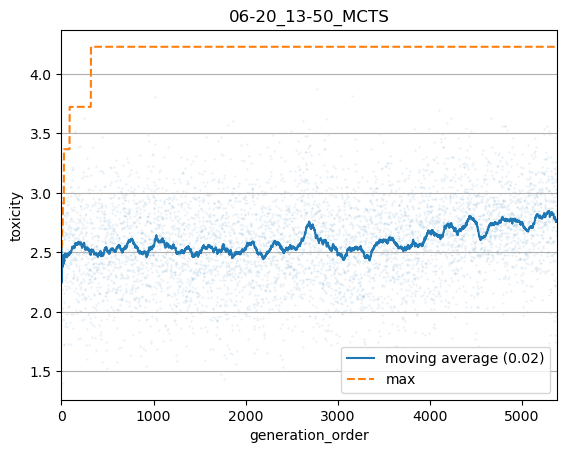

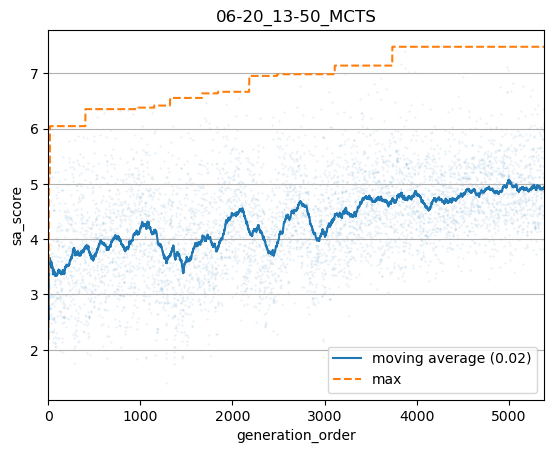

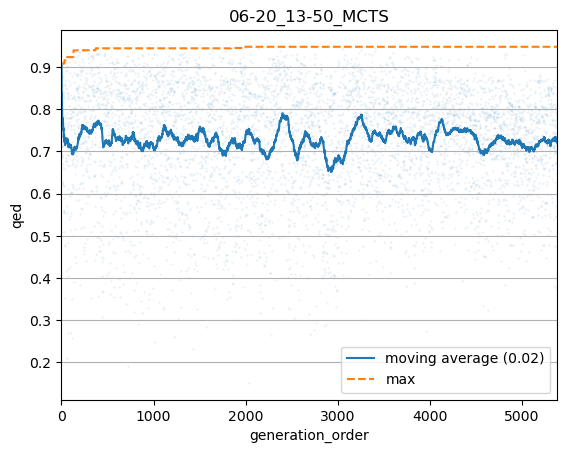

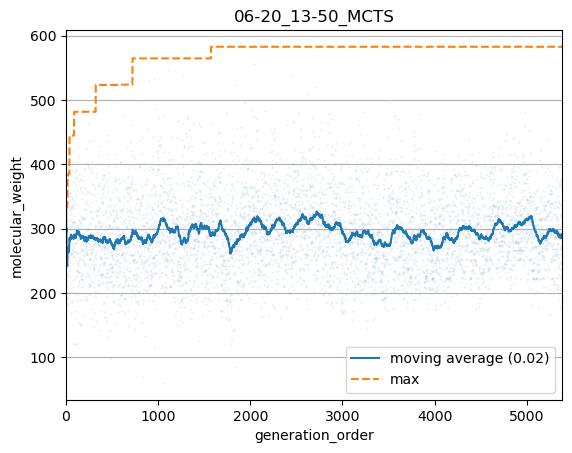

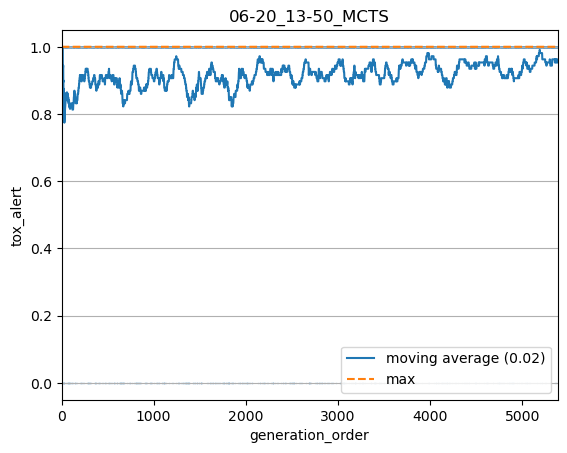

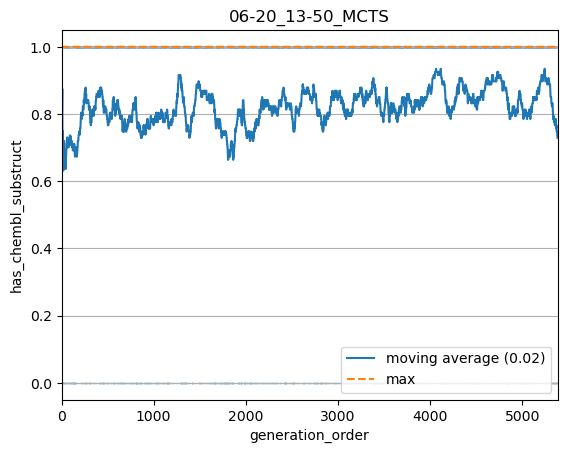

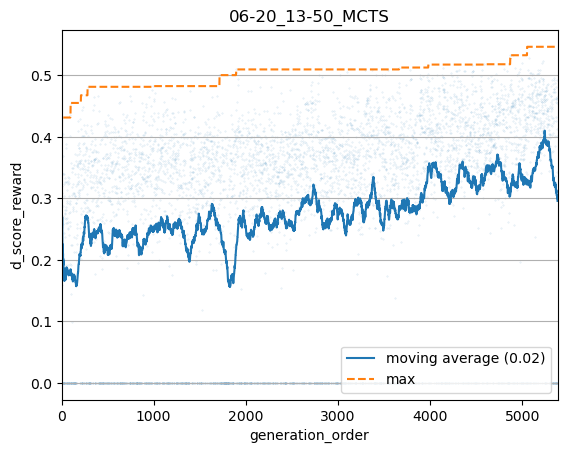

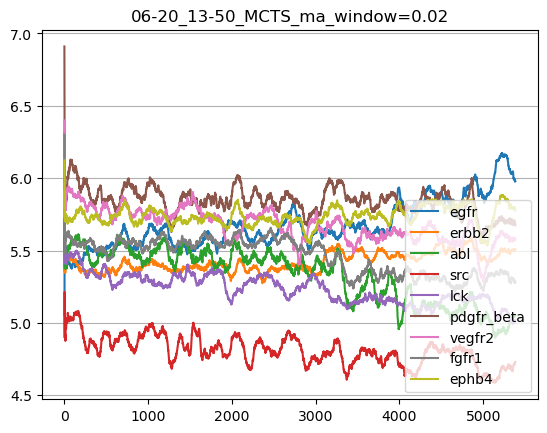

number of generated nodes: 5383
valid rate: 0.6522628791526239
unique rate: 0.9957871930669234
node_per_sec: 43.36520058507417


In [15]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
c3 = "config/mcts_smiles.yaml"
c4 = "config/model_test.yaml"
c5 = "config/mcts_d_score_diversion.yaml"
generator, conf = read_yaml(c5)
generate_and_analyze(generator, conf)
# queue_yaml(c1, c2)

In [ ]:
#continue search
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [4]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts test
load_path = generator.output_dir() + "save.mcts"
generator = MCTS.load(load_path, generator.transition) #TODO: separate notebook

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)